# SVDD Parametrization

This notebook gives an overview over different parametrization strategies implemented in the SVDD.jl package:

* Kernel Parameter Gamma
    - Fixed Gamma
    - Rule of Thumb Scott [3]
    - Rule of Thumb Silverman [4]
    - Mean Criterion [5]
    - Modified Mean Criterion [6]
    - Wang data shifting [7]
* Cost Parameter C
    - Fixed C
    - Rule of Tax [1]
    - Binary Search
* Combined C and Gamma
    - Wang data shifting [7]
    
We apply these strategies with the standard SVDD [1] on a small example data set.

[1] Tax, David MJ, and Robert PW Duin. "Support vector data description." Machine learning 54.1 (2004): 45-66. <br>
[2] Görnitz, Nico, et al. "Toward supervised anomaly detection." Journal of Artificial Intelligence Research 46 (2013): 235-262.<br>
[3] Scott, David W. Multivariate density estimation: theory, practice, and visualization. John Wiley & Sons, 2015.<br>
[4] Silverman, Bernard W. Density estimation for statistics and data analysis. Routledge, 2018.<br>
[5] Chaudhuri, Arin, et al. "The mean and median criteria for kernel bandwidth selection for support vector data description." 2017 IEEE International Conference on Data Mining Workshops (ICDMW). IEEE, 2017.<br>
[6] Liao, Yuwei, et al. "A new bandwidth selection criterion for using SVDD to analyze hyperspectral data." Algorithms and Technologies for Multispectral, Hyperspectral, and Ultraspectral Imagery XXIV. Vol. 10644. International Society for Optics and Photonics, 2018.<br>
[7] Wang, Siqi, et al. "Hyperparameter selection of one-class support vector machine by self-adaptive data shifting." Pattern Recognition 74 (2018): 198-211.

In [1]:
using Pkg
Pkg.activate("..")
using Distributions
using Ipopt
using Random
using SVDD
using JuMP
using MLKernels
using Printf
using Plots

Define plotting function:

In [2]:
function Plots.plot(m::OCClassifier; prec=0, binary_tuning_data=nothing, title="")
    r = range(-0.5, 1.5, length = 100)
    grid = hcat([[x,y] for x in r for y in r]...)
    grid_predictions = SVDD.predict(m, grid)
    predictions = SVDD.predict(m, m.data)
    data = m.data
    grid_p = grid_predictions .- prec
    contourf(r, r, reshape(grid_p , length(r), length(r)), levels=range(0, maximum(grid_predictions), length=20), color=:blues)
    out = predictions .> prec
    scatter!(data[1, .!out], data[2, .!out], color=[:white])
    scatter!(data[1, out], data[2, out], color=[:red])
    if binary_tuning_data !== nothing
        scatter!(binary_tuning_data[1][1,:], binary_tuning_data[1][2,:], color=[:white], markershape=:dtriangle)
        scatter!(binary_tuning_data[2][1,:], binary_tuning_data[2][2,:], color=[:red], markershape=:utriangle)
    end
    contour!(r, r, reshape(grid_p , length(r), length(r)), levels=[0], linewidth=2, color=:black, cbar=false, legend=false)
end

In [3]:
solver = with_optimizer(Ipopt.Optimizer, print_level=0)
Random.seed!(42);

Generate some test data:

In [4]:
n = 100
d1 = [[o, (5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n)]
d2 = [[o, -(5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n)]
d3 = [reshape(rand(70), 2, 35)]
dummy_data = hcat(d1..., d2..., d3...)
labels = fill(:U, size(dummy_data,2));

Define helper function to train a SVDD and plot the decision boundary:

In [5]:
function train_and_plot_svdd(data, init_strategy, solver, binary_tuning_data=nothing)
    model = SVDD.VanillaSVDD(data)
    SVDD.initialize!(model, init_strategy)
    SVDD.fit!(model, solver)
    p = Plots.plot(model, binary_tuning_data=binary_tuning_data)
    return Plots.plot(p, title="C = $(model.C), gamma = $(@sprintf("%.4f", model.kernel_fct.alpha.value.x))")
end

train_and_plot_svdd (generic function with 2 methods)

# Fixed Parameters


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



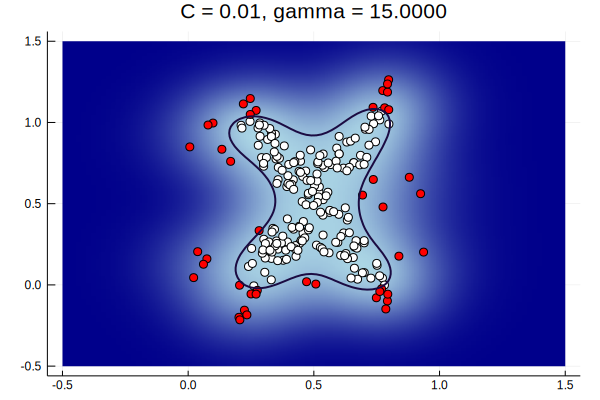

In [6]:
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)),
                                            SVDD.FixedCStrategy(0.01))
train_and_plot_svdd(dummy_data, init_strategy, solver)

If we increase the gamma parameter from $\gamma = 15$ to $\gamma = 500$ the SVDD starts to overfit:

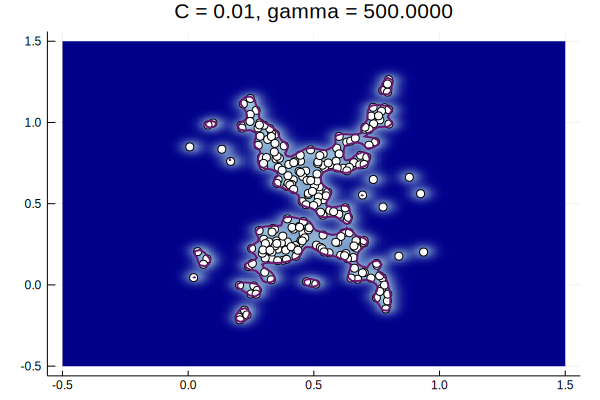

In [7]:
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(500)),
                                            SVDD.FixedCStrategy(0.01))
train_and_plot_svdd(dummy_data, init_strategy, solver)

## Gamma Parameter

SVDD.jl implements multiple strategies to choose $\gamma$ (gamma) independent of C.

### Rule of Thumb

Scott and Silverman proposed two rule of thumbs that infer $\gamma$ from the size $n$ and dimensionality $d$ of the data set. Both rules first calculate the kernel bandwidth $s$ and then set $\gamma = 1 / (2 * s^2)$.

$s_{\text{scott}} = n^{{-1}/({d+4})}$<br>
$s_{\text{silverman}} = (n(d+2)/4)^{{-1}/({d+4})}$

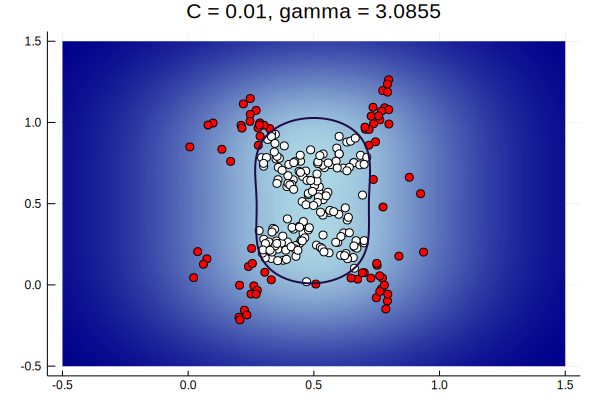

In [8]:
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.RuleOfThumbScott(),
                                            SVDD.FixedCStrategy(0.01))
p = train_and_plot_svdd(dummy_data, init_strategy, solver)

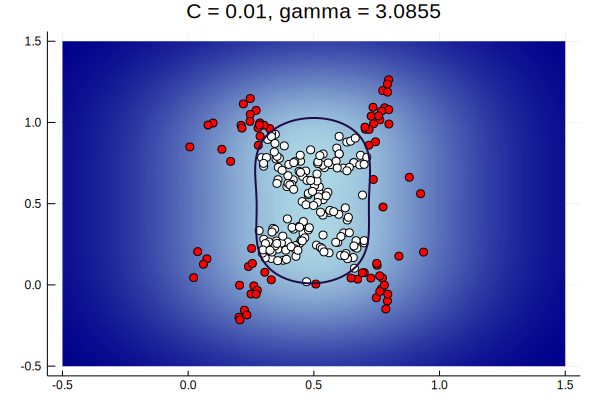

In [9]:
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.RuleOfThumbSilverman(),
                                            SVDD.FixedCStrategy(0.01))
train_and_plot_svdd(dummy_data, init_strategy, solver)

Both rule of thumbs result in the same value for $\gamma$, due to $d = 2$ and $(d+2)/4 = 1$.

### Mean criterion

The mean criterion includes the variance of the data in the kernel bandwidth $s$ calculation. Here, $\sigma_j^2$ indicates the variance in each dimension. The parameter $\delta$ controls the distance to the identity matrix.
The SVDD allows manual configuration of the $\delta$ parameter. Additionally, we implement the recommended value $\delta = \sqrt{2}*10^{-6}$.

$s = \sqrt{\dfrac{2n*\sum_{j=1}^d\sigma_j^2}{(n-1)\ln\left(\dfrac{n-1}{\delta^2}\right)}}$

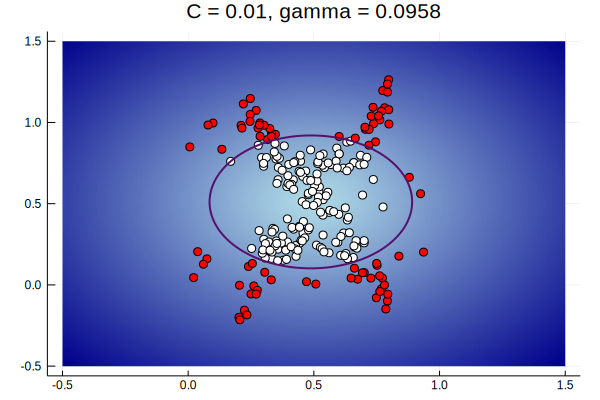

In [10]:
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.MeanCriterion(),
                                            SVDD.FixedCStrategy(0.01))
train_and_plot_svdd(dummy_data, init_strategy, solver)

Kadke et al. propose a modified mean criterion which automatically selects the value $\delta$ based on the data set size in [].

$ϕ = \dfrac{1}{\ln\left(N - 1\right)}$<br>
$δ = -0.14818008 * ϕ^4 + 0.284623624 * ϕ^3 - 0.252853808 * ϕ^2 + 0.159059498 * ϕ - 0.001381145$

The kernel bandwidth is the calculated as with the original mean criterion (see previous block).

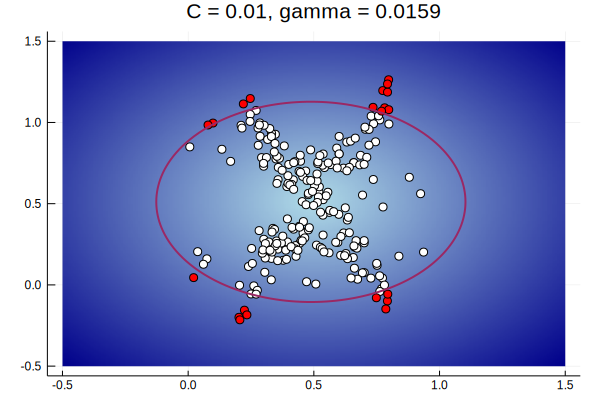

In [11]:
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.ModifiedMeanCriterion(),
                                            SVDD.FixedCStrategy(0.01))
train_and_plot_svdd(dummy_data, init_strategy, solver)

### Wang Data Shifting

The wang data shifting strategy first generates pseudo inliers and outliers. Then, it tunes the kernel parameter in a second step to optimize prediction quality on this generated test data.

*Note:* We made some changes compared to the original algorithm proposed in [7], for details see [here](https://github.com/englhardt/SVDD.jl/blob/master/src/init_strategies/strategies_gamma.jl#L92).

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 3.774758283725532e-14. The sum of adjustments is 2.1040980069386706e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 2.708944180085382e-14. The sum of adjustments is 1.6585532947033244e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 3.863576125695545e-14. The sum of adjustments is 1.239055524848709e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 1.354472090042691e-14. The sum of adjustments is 1.1630169050036443e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 4.529709940470639e-14. The sum of adjustments is 1.2545849081835314e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KER

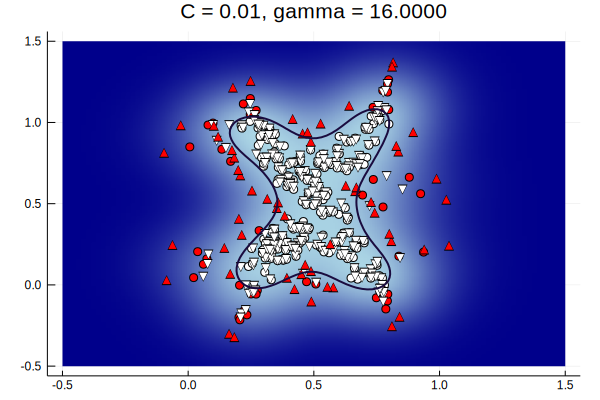

In [12]:
binary_tuning_data = SVDD.generate_binary_data_for_tuning(dummy_data)
gamma_search_range = 2.0.^range(-4, stop=4, step=1.0)
C = 1.0
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.WangGammaStrategy(solver, gamma_search_range, C),
                                            SVDD.FixedCStrategy(0.01))
train_and_plot_svdd(dummy_data, init_strategy, solver, binary_tuning_data)

The triangles are the artificial tuning data, where artificial inliers are the white ones and artificial outliers the red ones.

## C Strategy

Given a target outlier percentage Tax et al. proposed a rule of thumb to estimate C [1].

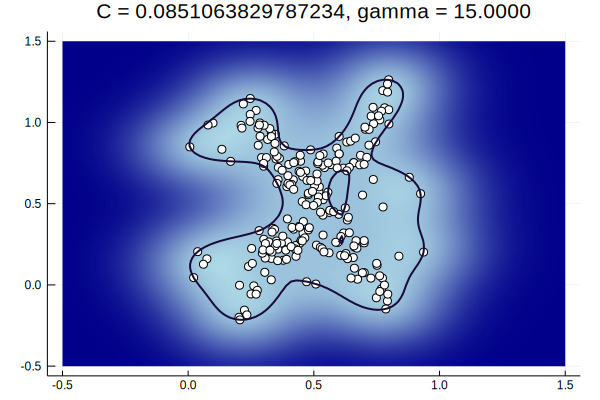

In [13]:
target_outlier_percentage = 0.05
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)),
                                            SVDD.TaxErrorEstimate(target_outlier_percentage))
train_and_plot_svdd(dummy_data, init_strategy, solver)

We propose to use `BoundedTaxErrorEstimate` which is similar to the previous strategy but bounds C into a certain interval `[lower_bound, upper_bound]`, e.g., `BoundedTaxErrorEstimate(0.05, 0.02, 0.98)`. We do this to avoid extreme cases where C gets very low or very high and the optimization problem becomes infeasible.

`BinarySearchCStrategy(target_outlier_percentage, solver)` performs a binary search in the interval $C \in [0, 1]$ to find a parameter $C$ that results in specified `target_outlier_percentage`.<br>
Constructor: `BoundedTaxErrorEstimate(target_outlier_percentage, lower_bound, upper_bound)` or the full constructor `BoundedTaxErrorEstimate(target_outlier_percentage, C_init, max_iter, prediction_eps, solver)`.



## Combined Gamma and C Strategy

`WangCombinedInitializationStrategy` first calculates C with a given `C_strategy` and then tunes gamma with the artificial binary tuning data.

Constructor: `WangCombinedInitializationStrategy(solver, gamma_search_range, C_strategy)` or `WangCombinedInitializationStrategy(solver, C_strategy)`.

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 4.118927421359331e-14. The sum of adjustments is 1.8087320530213447e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 1.9317880628477724e-14. The sum of adjustments is 1.1982603798088576e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 1.4432899320127035e-14. The sum of adjustments is 1.3481615823707216e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 4.529709940470639e-14. The sum of adjustments is 1.2545849081835314e-10
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 1.3877787807814457e-14. The sum of adjustments is 8.481462927811823e-11
[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST 

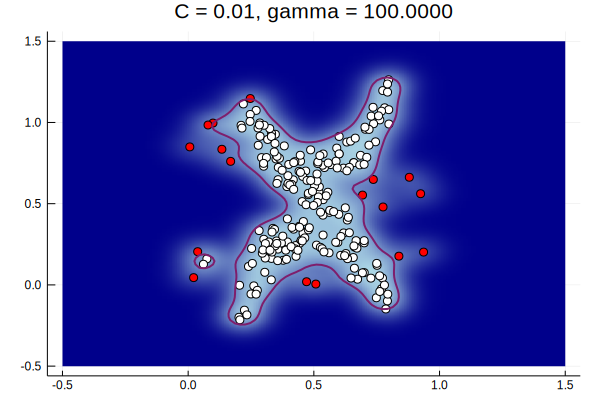

In [14]:
gamma_search_range = 10.0.^range(-1, stop=2, length=10)
C_strategy = FixedCStrategy(0.01)
init_strategy = SVDD.WangCombinedInitializationStrategy(solver, gamma_search_range, C_strategy)
train_and_plot_svdd(dummy_data, init_strategy, solver)

## Final remarks

For more details on how we set the gamma and C parameter in our one-class active learning article [8], see the [code on github here](https://github.com/kit-dbis/ocal-evaluation).

[8] Holger Trittenbach, Adrian Englhardt, Klemens Böhm, "An Overview and a Benchmark of Active Learning for One-Class Classification" arXiv:1808.04759, 14 Aug 2018.